In [65]:
import os
import json
import numpy as np
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import itertools

#import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


#Change directory
os.chdir("E:/Github/Revenue-Radar/Data")

In [66]:
#Reading dataset
train_df = pd.read_csv('train_df.csv')

# Identifying and collecting names of columns in `train_df` with constant values (including NaNs).
# This includes columns where all rows have the same value, making them non-informative for analysis.
# These columns are appended to the `null` list for potential removal or further investigation.

null = []
for n in train_df.columns:
    if train_df[n].nunique(dropna=False) == 1:
        null.append(n)
        
# `null` now contains the names of all such constant columns.
null

C:\Users\pc\AppData\Local\Temp\ipykernel_5852\1307773894.py:1: DtypeWarning:

Columns (2,34) have mixed types. Specify dtype option on import or set low_memory=False.



[]

In [67]:
train_df.head()
train_df.columns.to_list()

['channelGrouping',
 'date',
 'fullVisitorId',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'device.browser',
 'device.operatingSystem',
 'device.isMobile',
 'device.deviceCategory',
 'geoNetwork.continent',
 'geoNetwork.subContinent',
 'geoNetwork.country',
 'geoNetwork.region',
 'geoNetwork.metro',
 'geoNetwork.city',
 'geoNetwork.networkDomain',
 'totals.hits',
 'totals.pageviews',
 'totals.bounces',
 'totals.newVisits',
 'totals.transactionRevenue',
 'trafficSource.campaign',
 'trafficSource.source',
 'trafficSource.medium',
 'trafficSource.keyword',
 'trafficSource.isTrueDirect',
 'trafficSource.referralPath',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.adContent',
 'trafficSource.campaignCode']

In [68]:
# Grouping columns of `train_df` based on the first character of their names and printing the groups.
# This helps in identifying patterns or categorizations in the column names, which might be useful for batch processing or analysis.
# The columns are first sorted alphabetically, then grouped by their starting character using itertools.groupby.

columns = sorted(train_df.columns.tolist())
grouped_columns = [list(group) for key, group in itertools.groupby(columns, lambda x: x[0])]

for group in grouped_columns:
    print(", ".join(group))

channelGrouping
date, device.browser, device.deviceCategory, device.isMobile, device.operatingSystem
fullVisitorId
geoNetwork.city, geoNetwork.continent, geoNetwork.country, geoNetwork.metro, geoNetwork.networkDomain, geoNetwork.region, geoNetwork.subContinent
totals.bounces, totals.hits, totals.newVisits, totals.pageviews, totals.transactionRevenue, trafficSource.adContent, trafficSource.adwordsClickInfo.adNetworkType, trafficSource.adwordsClickInfo.gclId, trafficSource.adwordsClickInfo.isVideoAd, trafficSource.adwordsClickInfo.page, trafficSource.adwordsClickInfo.slot, trafficSource.campaign, trafficSource.campaignCode, trafficSource.isTrueDirect, trafficSource.keyword, trafficSource.medium, trafficSource.referralPath, trafficSource.source
visitId, visitNumber, visitStartTime


In [69]:
#drop the columns that have not available in demo dataset
columns_to_drop = [col for col in train_df.columns if train_df[col].eq('NaN').any()]
df_dropped = train_df.drop(columns=columns_to_drop)

In [70]:
#check the na percentage compare to total data
na_percentage = df_dropped.isna().sum() / len(df_dropped)
na_percentage = na_percentage.sort_values(ascending=False)

na_percentage

trafficSource.campaignCode                      0.999999
trafficSource.adContent                         0.987887
totals.transactionRevenue                       0.987257
trafficSource.adwordsClickInfo.isVideoAd        0.976252
trafficSource.adwordsClickInfo.adNetworkType    0.976252
trafficSource.adwordsClickInfo.slot             0.976252
trafficSource.adwordsClickInfo.page             0.976252
trafficSource.adwordsClickInfo.gclId            0.976140
trafficSource.isTrueDirect                      0.696781
trafficSource.referralPath                      0.633774
trafficSource.keyword                           0.556551
totals.bounces                                  0.501324
totals.newVisits                                0.221980
totals.pageviews                                0.000111
trafficSource.medium                            0.000000
trafficSource.source                            0.000000
trafficSource.campaign                          0.000000
channelGrouping                

Percentage of customers producing revenue: 1.40%

In [71]:
# Calculating and printing the percentage of customers who generate revenue.
# This process involves grouping the dataset by unique customer IDs to sum up their total transaction revenue
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

# converting the revenue data to numeric format and handling any non-numeric values by coercion to NaN
gdf["totals.transactionRevenue"] = pd.to_numeric(gdf["totals.transactionRevenue"], errors="coerce")

# then dropping any rows with NaN values in the revenue column to ensure data integrity.
gdf = gdf.dropna(subset=["totals.transactionRevenue"])

# The revenue data is intended to be sorted in ascending order to facilitate the calculation of the percentage of revenue-generating customers.
gdf["totals.transactionRevenue"] = np.sort(gdf["totals.transactionRevenue"])

# Finally, the script calculates the total number of customers and the number of those generating more than 0 revenue,
total_customers = gdf.shape[0]
revenue_customers = gdf[gdf["totals.transactionRevenue"] > 0].shape[0]
percentage_revenue_customers = (revenue_customers / total_customers) * 100

# computing the percentage of revenue-generating customers relative to the total customer base and printing the result.
print("Percentage of customers producing revenue: {:.2f}%".format(percentage_revenue_customers))

Percentage of customers producing revenue: 1.40%


## Regression model on revenue (Only with data that percentage of customers producing data)

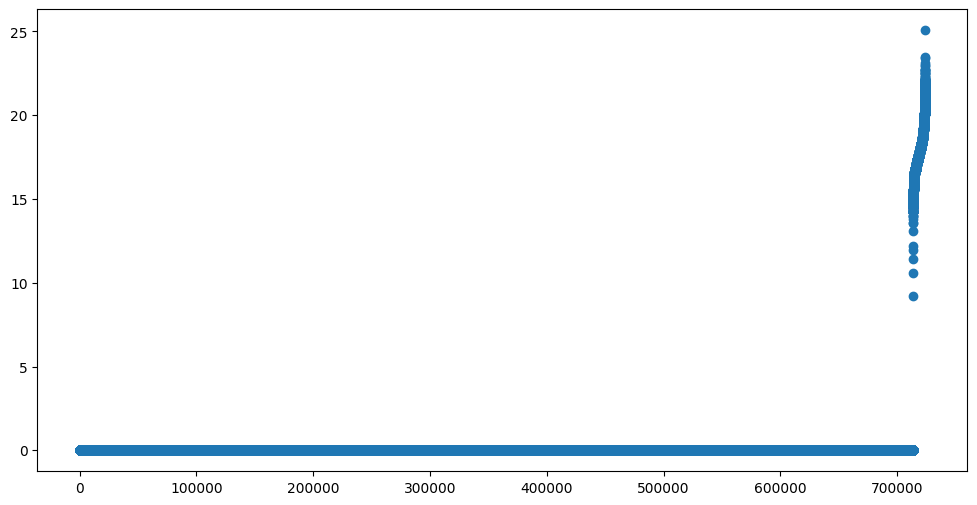

In [72]:
# Plotting the distribution of the total revenue
plt.figure(figsize=(12,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))

In [73]:
# check how many data we have for each column
count = df_dropped.count()
count = count.sort_values(ascending=False)
count

channelGrouping                                 903653
geoNetwork.subContinent                         903653
trafficSource.medium                            903653
trafficSource.source                            903653
trafficSource.campaign                          903653
date                                            903653
geoNetwork.networkDomain                        903653
geoNetwork.city                                 903653
geoNetwork.metro                                903653
geoNetwork.region                               903653
geoNetwork.country                              903653
totals.hits                                     903653
geoNetwork.continent                            903653
visitStartTime                                  903653
fullVisitorId                                   903653
device.deviceCategory                           903653
visitNumber                                     903653
visitId                                         903653
device.bro

In [74]:
"""
trafficSource.campaignCode                      0.999999
trafficSource.adContent                         0.987887
totals.transactionRevenue                       0.987257
trafficSource.adwordsClickInfo.isVideoAd        0.976252
trafficSource.adwordsClickInfo.adNetworkType    0.976252
trafficSource.adwordsClickInfo.slot             0.976252
trafficSource.adwordsClickInfo.page             0.976252
trafficSource.adwordsClickInfo.gclId            0.976140
trafficSource.isTrueDirect                      0.696781
trafficSource.referralPath                      0.633774
trafficSource.keyword                           0.556551
totals.bounces                                  0.501324
"""
#drop these columns
df_1 = df_dropped.drop(columns=['trafficSource.campaignCode', 'trafficSource.adContent', 
                                       'trafficSource.adwordsClickInfo.isVideoAd', 
                                      'trafficSource.adwordsClickInfo.adNetworkType', 
                                      'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.page', 
                                      'trafficSource.adwordsClickInfo.gclId', 
                                      'trafficSource.isTrueDirect', 'trafficSource.referralPath', 
                                      'trafficSource.keyword', 'totals.bounces', 'fullVisitorId', 'visitId'])

# what if drop na
df_2 = df_1.dropna()

# check how many data left
count1 = df_1.count()
count1 = count1.sort_values(ascending=False)

count2 = df_2.count()
count2 = count2.sort_values(ascending=False)


print(count1)
print(count2)


channelGrouping              903653
geoNetwork.country           903653
trafficSource.source         903653
trafficSource.campaign       903653
totals.hits                  903653
geoNetwork.networkDomain     903653
geoNetwork.city              903653
geoNetwork.metro             903653
date                         903653
geoNetwork.region            903653
geoNetwork.subContinent      903653
geoNetwork.continent         903653
device.deviceCategory        903653
device.isMobile              903653
device.operatingSystem       903653
device.browser               903653
visitStartTime               903653
visitNumber                  903653
trafficSource.medium         903653
totals.pageviews             903553
totals.newVisits             703060
totals.transactionRevenue     11515
dtype: int64
channelGrouping              4465
date                         4465
trafficSource.source         4465
trafficSource.campaign       4465
totals.transactionRevenue    4465
totals.newVisits         

In [75]:
df_2 = df_1.copy()

In [76]:
# only use the data that has transaction revenue
df_2 = df_2[df_2['totals.transactionRevenue'] > 0]

# check how many data left
count2 = df_2.count()
count2 = count2.sort_values(ascending=False)
count2

channelGrouping              11515
date                         11515
trafficSource.source         11515
trafficSource.campaign       11515
totals.transactionRevenue    11515
totals.pageviews             11515
totals.hits                  11515
geoNetwork.networkDomain     11515
geoNetwork.city              11515
geoNetwork.metro             11515
geoNetwork.region            11515
geoNetwork.country           11515
geoNetwork.subContinent      11515
geoNetwork.continent         11515
device.deviceCategory        11515
device.isMobile              11515
device.operatingSystem       11515
device.browser               11515
visitStartTime               11515
visitNumber                  11515
trafficSource.medium         11515
totals.newVisits              4465
dtype: int64

In [77]:
import pandas as pd

# Assuming df_2 is your DataFrame and has already been loaded

# Step 1: Convert 'totals.newVisits' to categorical
df_2['totals.newVisits'] = df_2['totals.newVisits'].astype('category')

# Check unique values before making changes
print("Unique values before:", df_2['totals.newVisits'].unique())

# Step 2: Fill NA/NaN values with 0
df_2['totals.newVisits'] = df_2['totals.newVisits'].cat.add_categories([0]).fillna(0)

# Step 3: Ensure all values are either 1 or 0
df_2['totals.newVisits'] = df_2['totals.newVisits'].apply(lambda x: 1 if x == 1 else 0).astype('category')

# Check unique values after making changes
print("Unique values after:", df_2['totals.newVisits'].unique())


Unique values before: [1.0, NaN]
Categories (1, float64): [1.0]
Unique values after: [1, 0]
Categories (2, int64): [1, 0]


In [78]:
df_2.head()

,channelGrouping,date,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,...,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium
752,Direct,20160902,1,1472843572,Chrome,Linux,False,desktop,Americas,Northern America,...,Detroit MI,Ann Arbor,(not set),11,11.0,1,37860000.0,(not set),(direct),(none)
753,Organic Search,20160902,3,1472844906,Chrome,Macintosh,False,desktop,Americas,Northern America,...,New York NY,New York,(not set),11,10.0,0,306670000.0,(not set),google,organic
799,Referral,20160902,7,1472827393,Chrome,Linux,False,desktop,Americas,Northern America,...,New York NY,New York,(not set),13,11.0,0,68030000.0,(not set),mall.googleplex.com,referral
802,Referral,20160902,6,1472846398,Chrome,Windows,False,desktop,Americas,Northern America,...,San Francisco-Oakland-San Jose CA,Mountain View,(not set),13,12.0,0,26250000.0,(not set),mall.googleplex.com,referral
859,Referral,20160902,4,1472824817,Chrome,Macintosh,False,desktop,Americas,Northern America,...,not available in demo dataset,not available in demo dataset,(not set),17,14.0,0,574150000.0,(not set),mall.googleplex.com,referral


In [79]:
# make date to datetime
df_2['date'] = pd.to_datetime(df_2['date'], format='%Y%m%d')

In [80]:
df_2.dtypes

channelGrouping                      object
date                         datetime64[ns]
visitNumber                           int64
visitStartTime                        int64
device.browser                       object
device.operatingSystem               object
device.isMobile                        bool
device.deviceCategory                object
geoNetwork.continent                 object
geoNetwork.subContinent              object
geoNetwork.country                   object
geoNetwork.region                    object
geoNetwork.metro                     object
geoNetwork.city                      object
geoNetwork.networkDomain             object
totals.hits                           int64
totals.pageviews                    float64
totals.newVisits                   category
totals.transactionRevenue           float64
trafficSource.campaign               object
trafficSource.source                 object
trafficSource.medium                 object
dtype: object

# NOT include Time Series


In [81]:
#type of each row
df_2.dtypes
#drop the date
df_3 = df_2.drop(columns=['geoNetwork.metro','geoNetwork.networkDomain','visitNumber','geoNetwork.city',
                          'visitStartTime','trafficSource.source'])
df_3.head()

,channelGrouping,date,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,totals.hits,totals.pageviews,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.medium
752,Direct,2016-09-02,Chrome,Linux,False,desktop,Americas,Northern America,United States,Michigan,11,11.0,1,37860000.0,(not set),(none)
753,Organic Search,2016-09-02,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,New York,11,10.0,0,306670000.0,(not set),organic
799,Referral,2016-09-02,Chrome,Linux,False,desktop,Americas,Northern America,United States,New York,13,11.0,0,68030000.0,(not set),referral
802,Referral,2016-09-02,Chrome,Windows,False,desktop,Americas,Northern America,United States,California,13,12.0,0,26250000.0,(not set),referral
859,Referral,2016-09-02,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,not available in demo dataset,17,14.0,0,574150000.0,(not set),referral


In [82]:
#check the unique value of each column for categorical data
for col in df_3.columns:
    if df_3[col].dtype == 'object':
        print(col, df_3[col].nunique())
        print('\n')
        # print each unique value
        print(df_3[col].unique())
        print('\n')
        # print the value counts
        print(df_3[col].value_counts())
    else:
        continue


        

channelGrouping 8


['Direct' 'Organic Search' 'Referral' 'Display' 'Paid Search' 'Social'
 'Affiliates' '(Other)']


channelGrouping
Referral          5311
Organic Search    3438
Direct            2042
Paid Search        468
Display            142
Social             104
Affiliates           9
(Other)              1
Name: count, dtype: int64
device.browser 9


['Chrome' 'Safari' 'Firefox' 'Safari (in-app)' 'Edge' 'Internet Explorer'
 'Android Webview' 'Opera' 'Amazon Silk']


device.browser
Chrome               10353
Safari                 780
Firefox                191
Internet Explorer      109
Edge                    58
Safari (in-app)         12
Android Webview          6
Opera                    5
Amazon Silk              1
Name: count, dtype: int64
device.operatingSystem 7


['Linux' 'Macintosh' 'Windows' 'Android' 'Chrome OS' 'iOS' 'Windows Phone']


device.operatingSystem
Macintosh        6426
Windows          2309
Chrome OS         994
Linux             782
iOS               5

In [83]:
df_4 = df_3.drop(columns=['geoNetwork.subContinent','trafficSource.campaign','geoNetwork.continent'])


In [84]:


# Assuming your DataFrame is named df (replace with the actual name of your DataFrame)

# Filter the DataFrame to include only rows where 'geoNetwork.country' is 'United States' or 'Canada'
df_4= df_4[(df_4['geoNetwork.country'] == 'United States')]

# drop country column
df_4 = df_4.drop(columns=['geoNetwork.country'])

# Now, filtered_df contains only the rows with 'United States' and 'Canada'


print(df_4['geoNetwork.region'].unique())


['Michigan' 'New York' 'California' 'not available in demo dataset'
 'Washington' 'Illinois' 'Oregon' 'District of Columbia' 'Massachusetts'
 '(not set)' 'Virginia' 'Georgia' 'Texas' 'Pennsylvania' 'Nevada'
 'North Carolina' 'State of Rio de Janeiro' 'Colorado' 'New Jersey'
 'Florida' 'Nebraska' 'South Carolina' 'Utah' 'Tennessee' 'Zulia'
 'Ontario' 'Arizona' 'Ohio' 'Iowa' 'Catalonia' 'Missouri' 'Vienna'
 'Maryland' 'Minnesota' 'England' 'Indiana' 'Connecticut' 'Quebec'
 'Wisconsin']


In [85]:
df_4['channelGrouping'] = df_4['channelGrouping'].replace(['Social', 'Display', 'Affiliates', '(Other)'], 'Other')
print(df_4['channelGrouping'].value_counts())


browsers_to_keep = ['Chrome']
df_4['device.browser'] = df_4['device.browser'].apply(lambda x: x if x in browsers_to_keep else 'Rest')
# After the modification, to see the count of each category, you can use value_counts()
print(df_4['device.browser'].value_counts())


# For the 'device.operatingSystem' column
# Replace 'Macintosh' with 'Mac', 'Windows' remains the same, and classify others as 'Mobile'
df_4['device.operatingSystem'] = df_4['device.operatingSystem'].replace(['Linux', 'Android', 'iOS', 'Chrome OS','Windows Phone'], 'Mobile')
df_4['device.operatingSystem'] = df_4['device.operatingSystem'].replace(['Macintosh'], 'Mac')

# Assuming 'device.deviceCategory' needs to be updated based on 'device.operatingSystem'
# This step seems a bit confusing because 'deviceCategory' typically indicates the type of device (e.g., desktop, mobile, tablet)
# If you intended to classify 'deviceCategory' based on 'operatingSystem', let's clarify the approach:
# - 'Mac' and 'Windows' could be considered 'desktop' in many contexts
# - 'Mobile' could map to 'mobile' and 'tablet'
# If the task is to adjust 'device.deviceCategory' based on these new 'operatingSystem' categories:
df_4['device.deviceCategory'] = df_4['device.operatingSystem'].apply(lambda x: 'desktop' if x in ['Mac', 'Windows'] else 'mobile')

# drop device category
df_4 = df_4.drop(columns=['device.deviceCategory'])

# After reclassification, to see the count of each category in 'device.operatingSystem'
print(df_4['device.operatingSystem'].value_counts())


df_4['geoNetwork.region'] = df_4['geoNetwork.region'].replace(['not available in demo dataset', '(not set)'], 'Unknown')


channelGrouping
Referral          5197
Organic Search    3111
Direct            1939
Paid Search        463
Other              243
Name: count, dtype: int64
device.browser
Chrome    9881
Rest      1072
Name: count, dtype: int64
device.operatingSystem
Mac        6176
Mobile     2674
Windows    2103
Name: count, dtype: int64


In [86]:
for col in df_4.columns:
    if df_4[col].dtype == 'object':
        print(col, df_4[col].nunique())
        print('\n')
        # print each unique value
        print(df_4[col].unique())
        print('\n')
        # print the value counts
        print(df_4[col].value_counts())
    else:
        continue


channelGrouping 5


['Direct' 'Organic Search' 'Referral' 'Other' 'Paid Search']


channelGrouping
Referral          5197
Organic Search    3111
Direct            1939
Paid Search        463
Other              243
Name: count, dtype: int64
device.browser 2


['Chrome' 'Rest']


device.browser
Chrome    9881
Rest      1072
Name: count, dtype: int64
device.operatingSystem 3


['Mobile' 'Mac' 'Windows']


device.operatingSystem
Mac        6176
Mobile     2674
Windows    2103
Name: count, dtype: int64
geoNetwork.region 38


['Michigan' 'New York' 'California' 'Unknown' 'Washington' 'Illinois'
 'Oregon' 'District of Columbia' 'Massachusetts' 'Virginia' 'Georgia'
 'Texas' 'Pennsylvania' 'Nevada' 'North Carolina'
 'State of Rio de Janeiro' 'Colorado' 'New Jersey' 'Florida' 'Nebraska'
 'South Carolina' 'Utah' 'Tennessee' 'Zulia' 'Ontario' 'Arizona' 'Ohio'
 'Iowa' 'Catalonia' 'Missouri' 'Vienna' 'Maryland' 'Minnesota' 'England'
 'Indiana' 'Connecticut' 'Quebec' 'Wisconsin']


geoNetwork.region


In [87]:
df_4['trafficSource.medium'] = df_4['trafficSource.medium'].replace('(none)', 'none')

# Combine 'cpc', 'cpm', 'affiliate', and '(not set)' into 'rest'
df_4['trafficSource.medium'] = df_4['trafficSource.medium'].replace(['cpc', 'cpm', 'affiliate', '(not set)'], 'rest')

# After reclassification, to see the count of each category
print(df_4['trafficSource.medium'].value_counts())

trafficSource.medium
referral    5289
organic     3111
none        1939
rest         614
Name: count, dtype: int64


In [88]:
import pandas as pd

# Assuming your DataFrame is named df and already has 'Unknown' consolidated

# Define the states as 'West' or 'East'
west_states = ['California', 'Washington', 'Texas', 'Colorado', 'Arizona', 'Oregon', 'Nevada', 'Utah']
east_states = ['New York', 'Illinois', 'Michigan', 'Massachusetts', 'Georgia', 'District of Columbia', 
               'Pennsylvania', 'New Jersey', 'North Carolina', 'Minnesota', 'Missouri', 'Florida', 
               'Tennessee', 'Iowa', 'Virginia', 'Indiana', 'Connecticut']

# Function to categorize each state
def categorize_state(region):
    if region in west_states:
        return 'West'
    elif region in east_states:
        return 'East'
    else:
        return 'Unknown'  # Keeps 'Unknown' and other unspecified regions as 'Unknown'

# Apply the categorization
df_4['geoNetwork.region'] = df_4['geoNetwork.region'].apply(categorize_state)

# Check the new categorization
print(df_4['geoNetwork.region'].value_counts())


geoNetwork.region
Unknown    4338
West       4005
East       2610
Name: count, dtype: int64


In [89]:
for col in df_4.columns:
    if df_4[col].dtype == 'object':
        print(col, df_4[col].nunique())
        print('\n')
        # print each unique value
        print(df_4[col].unique())
        print('\n')
        # print the value counts
        print(df_4[col].value_counts())
    else:
        continue


channelGrouping 5


['Direct' 'Organic Search' 'Referral' 'Other' 'Paid Search']


channelGrouping
Referral          5197
Organic Search    3111
Direct            1939
Paid Search        463
Other              243
Name: count, dtype: int64
device.browser 2


['Chrome' 'Rest']


device.browser
Chrome    9881
Rest      1072
Name: count, dtype: int64
device.operatingSystem 3


['Mobile' 'Mac' 'Windows']


device.operatingSystem
Mac        6176
Mobile     2674
Windows    2103
Name: count, dtype: int64
geoNetwork.region 3


['East' 'West' 'Unknown']


geoNetwork.region
Unknown    4338
West       4005
East       2610
Name: count, dtype: int64
trafficSource.medium 4


['none' 'organic' 'referral' 'rest']


trafficSource.medium
referral    5289
organic     3111
none        1939
rest         614
Name: count, dtype: int64


In [90]:
df_4.drop(columns=['device.isMobile'], inplace=True)    


In [91]:
# splitting the date column into year, month and day
df_4['month']=df_4['date'].dt.month
df_4['day']=df_4['date'].dt.day
df_4['year']=df_4['date'].dt.year

In [92]:
# bucketing month into quarters
def quarter(x):
    if x in [1,2,3]:
        return '1st_quarter'
    elif x in [4,5,6]:
        return '2nd_quarter'
    elif x in [7,8,9]:
        return '3rd_quarter'
    else:
        return '4th_quarter'
    
df_4['quarter']=df_4['month'].apply(quarter)

In [93]:
# bucking the day column into beginning, middle and end of the month
def day(x):
    if x in range(1,11):
        return 'beginning'
    elif x in range(11,21):
        return 'middle'
    else:
        return 'end'

df_4['day_of_month']=df_4['day'].apply(day)


In [94]:
df_4.drop(columns=['date'], inplace=True)

In [95]:
df_4.head()

,channelGrouping,device.browser,device.operatingSystem,geoNetwork.region,totals.hits,totals.pageviews,totals.newVisits,totals.transactionRevenue,trafficSource.medium,month,day,year,quarter,day_of_month
752,Direct,Chrome,Mobile,East,11,11.0,1,37860000.0,none,9,2,2016,3rd_quarter,beginning
753,Organic Search,Chrome,Mac,East,11,10.0,0,306670000.0,organic,9,2,2016,3rd_quarter,beginning
799,Referral,Chrome,Mobile,East,13,11.0,0,68030000.0,referral,9,2,2016,3rd_quarter,beginning
802,Referral,Chrome,Windows,West,13,12.0,0,26250000.0,referral,9,2,2016,3rd_quarter,beginning
859,Referral,Chrome,Mac,Unknown,17,14.0,0,574150000.0,referral,9,2,2016,3rd_quarter,beginning


In [96]:
df_4.drop(columns=['month', 'day'], inplace=True)

In [97]:
# give the type of each column
df_4.dtypes

channelGrouping                object
device.browser                 object
device.operatingSystem         object
geoNetwork.region              object
totals.hits                     int64
totals.pageviews              float64
totals.newVisits             category
totals.transactionRevenue     float64
trafficSource.medium           object
year                            int32
quarter                        object
day_of_month                   object
dtype: object

In [98]:
# from sklearn.preprocessing import LabelEncoder
# # Initialize a label encoder
# label_encoder = LabelEncoder()

# # Iterate through the columns
# for column in df_4.columns:
#     if df_4[column].dtype == 'object':
#         df_4[column] = label_encoder.fit_transform(df_4[column])
#     else:
#         continue

# df_4.head()


In [99]:
# drop the column that has high correlation
df_4 = df_4.drop(columns=['totals.hits', 'year', 'channelGrouping'])

In [100]:
# convert the column to int
df_4['totals.pageviews'] = df_4['totals.pageviews'].astype(int)

# dummy the categorical data
df_4 = pd.get_dummies(df_4, columns=[ 'device.browser', 'device.operatingSystem', 'geoNetwork.region', 'trafficSource.medium', 'quarter', 'day_of_month'], drop_first=True)

df_4.head()



,totals.pageviews,totals.newVisits,totals.transactionRevenue,device.browser_Rest,device.operatingSystem_Mobile,device.operatingSystem_Windows,geoNetwork.region_Unknown,geoNetwork.region_West,trafficSource.medium_organic,trafficSource.medium_referral,trafficSource.medium_rest,quarter_2nd_quarter,quarter_3rd_quarter,quarter_4th_quarter,day_of_month_end,day_of_month_middle
752,11,1,37860000.0,False,True,False,False,False,False,False,False,False,True,False,False,False
753,10,0,306670000.0,False,False,False,False,False,True,False,False,False,True,False,False,False
799,11,0,68030000.0,False,True,False,False,False,False,True,False,False,True,False,False,False
802,12,0,26250000.0,False,False,True,False,True,False,True,False,False,True,False,False,False
859,14,0,574150000.0,False,False,False,True,False,False,True,False,False,True,False,False,False


totals.pageviews
16     0.041998
15     0.041359
14     0.041267
13     0.039898
18     0.039624
         ...   
121    0.000091
119    0.000091
233    0.000091
305    0.000091
169    0.000091
Name: proportion, Length: 154, dtype: float64


totals.newVisits
0    0.613074
1    0.386926
Name: proportion, dtype: float64


totals.transactionRevenue
16990000.0     0.021638
33590000.0     0.016799
18990000.0     0.016708
44790000.0     0.015247
13590000.0     0.012143
                 ...   
84470000.0     0.000091
86800000.0     0.000091
412250000.0    0.000091
49520000.0     0.000091
69390000.0     0.000091
Name: proportion, Length: 5117, dtype: float64


device.browser_Rest
False    0.902127
True     0.097873
Name: proportion, dtype: float64


device.operatingSystem_Mobile
False    0.755866
True     0.244134
Name: proportion, dtype: float64


device.operatingSystem_Windows
False    0.807998
True     0.192002
Name: proportion, dtype: float64


geoNetwork.region_Unknown
False    0.603944
Tr

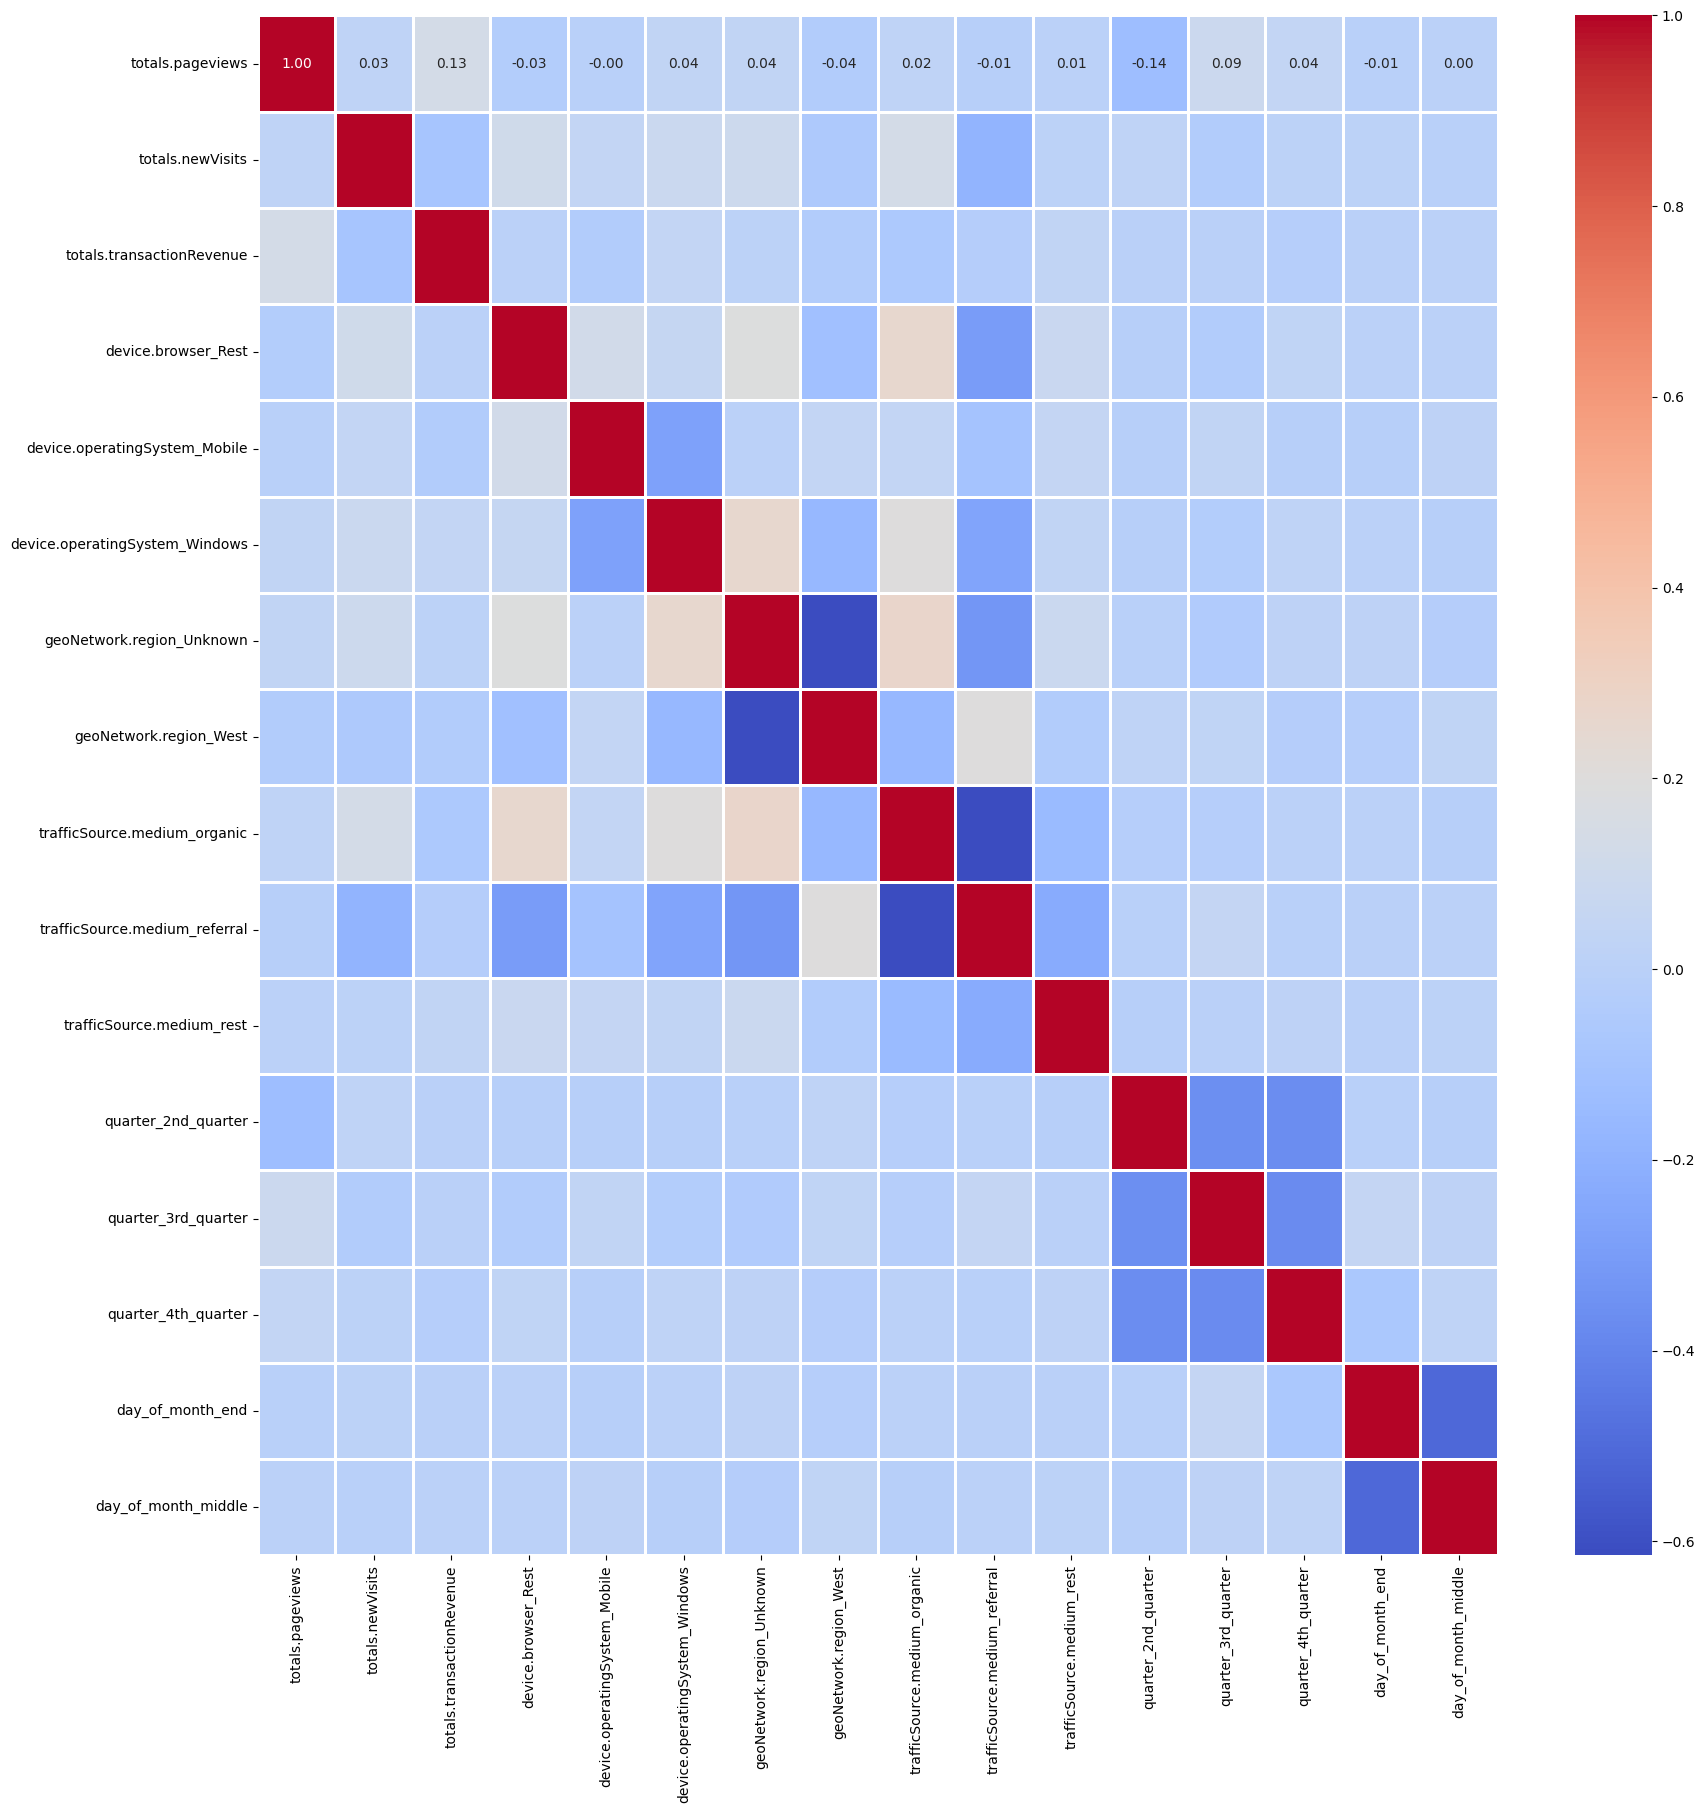

In [101]:
# give me the percentage of each value in the column
for column in df_4.columns:
    print(df_4[column].value_counts(normalize=True))
    print('\n')

# check the correlation between the columns
correlation = df_4.corr()
correlation

# plot the correlation
plt.figure(figsize=(20,20))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)
plt.show()


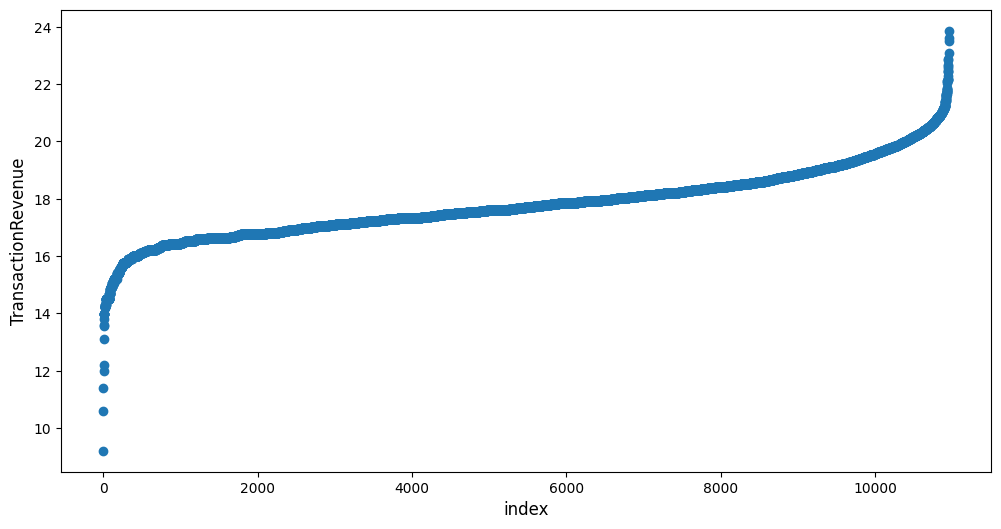

In [102]:
# plot the revenue
plt.figure(figsize=(12,6))
plt.scatter(range(df_4.shape[0]), np.sort(np.log1p(df_4["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()


In [103]:
df_5 = df_4.copy()
# get me the stats of the revenue in a table
print(df_5['totals.transactionRevenue'].min())
print(df_5['totals.transactionRevenue'].max())


10000.0
23129500000.0


In [104]:
# Min max on target
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#df_5['totals.transactionRevenue'] = scaler.fit_transform(df_5['totals.transactionRevenue'].values.reshape(-1,1))

df_5['totals.transactionRevenue'] = np.log1p(df_5['totals.transactionRevenue'].values)


In [105]:
# get me the stats of the revenue in a table
print(df_5['totals.transactionRevenue'].min())
print(df_5['totals.transactionRevenue'].max())

9.210440366976517
23.86437469605166


In [106]:
df_5.head()

,totals.pageviews,totals.newVisits,totals.transactionRevenue,device.browser_Rest,device.operatingSystem_Mobile,device.operatingSystem_Windows,geoNetwork.region_Unknown,geoNetwork.region_West,trafficSource.medium_organic,trafficSource.medium_referral,trafficSource.medium_rest,quarter_2nd_quarter,quarter_3rd_quarter,quarter_4th_quarter,day_of_month_end,day_of_month_middle
752,11,1,17.449406,False,True,False,False,False,False,False,False,False,True,False,False,False
753,10,0,19.541283,False,False,False,False,False,True,False,False,False,True,False,False,False
799,11,0,18.035459,False,True,False,False,False,False,True,False,False,True,False,False,False
802,12,0,17.083177,False,False,True,False,True,False,True,False,False,True,False,False,False
859,14,0,20.168401,False,False,False,True,False,False,True,False,False,True,False,False,False


# Linear Regression

Mean Squared Error: 1.2553020337491887
Mean Absolute Error: 0.8631839361660864
Median Absolute Error: 0.6871135181393289
Cross-validated scores: [0.85842117 0.81551634 0.85596021 0.87236524 0.85582436]
Average score: 0.8516174625464817
Intercept: 17.81686178043045
Coefficients: [ 0.30593111 -0.2029752  -0.084798   -0.0948675  -0.04434118 -0.12262109
 -0.10740589 -0.22252321 -0.16723227 -0.05742755  0.00887766 -0.01104059
 -0.03370372 -0.00427124  0.00217226]
Features: Index(['totals.pageviews', 'totals.newVisits', 'device.browser_Rest',
       'device.operatingSystem_Mobile', 'device.operatingSystem_Windows',
       'geoNetwork.region_Unknown', 'geoNetwork.region_West',
       'trafficSource.medium_organic', 'trafficSource.medium_referral',
       'trafficSource.medium_rest', 'quarter_2nd_quarter',
       'quarter_3rd_quarter', 'quarter_4th_quarter', 'day_of_month_end',
       'day_of_month_middle'],
      dtype='object')


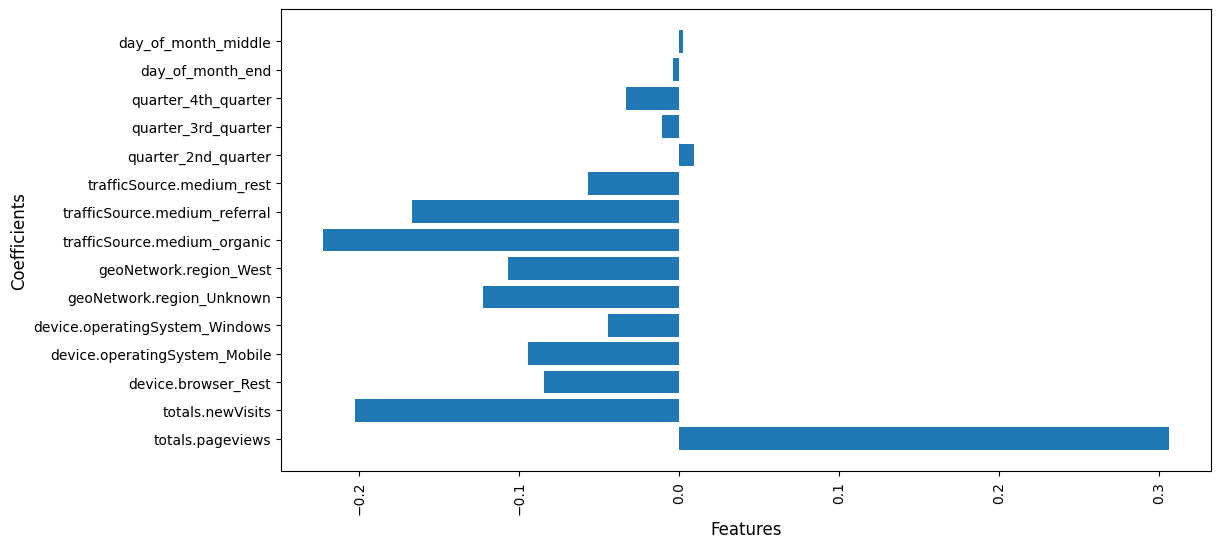

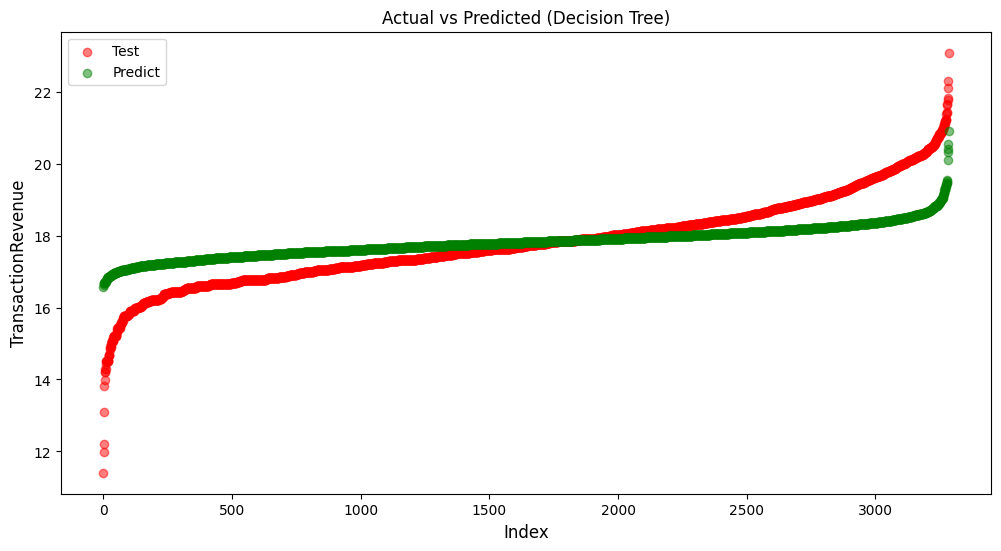

In [108]:
# Split the data into features and target
X = df_5.drop(columns='totals.transactionRevenue')
y = df_5['totals.transactionRevenue']

# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize a standard scaler
scaler = StandardScaler()

# Fit the scaler
scaler.fit(X_train)

# Scale the train and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error, median_absolute_error

# Initialize the model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Median Absolute Error
dae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)




print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Median Absolute Error:", dae)



#cross validation
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross validation
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Print the cross-validated scores
print('Cross-validated scores:', -scores)

# Print the average score
print('Average score:', -scores.mean())

# intercept and coefficients
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
print("Features:", X.columns)

# plot the coefficients
plt.figure(figsize=(12,6))
plt.barh(X.columns, model.coef_)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Coefficients', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Deviation Plot between Predict and Test in different colors
plt.figure(figsize=(12,6))
plt.scatter(range(len(y_test)), np.sort(y_test), color='r', label='Test', alpha=0.5)
plt.scatter(range(len(y_pred)), np.sort(y_pred), color='g', label='Predict', alpha=0.5)
 
plt.xlabel('Index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.title('Actual vs Predicted (Decision Tree)')
plt.legend()
plt.show()



# Lasso Regression

Mean Squared Error lasso: 1.3129285103044421
Mean Absolute Error lasso: 0.8822896325408653
Median Absolute Error lasso: 0.7113929687488447
Cross-validated scores lasso : [0.88022993 0.84531319 0.88936473 0.91074682 0.90121395]
Average score lasso: 0.8853737257136396


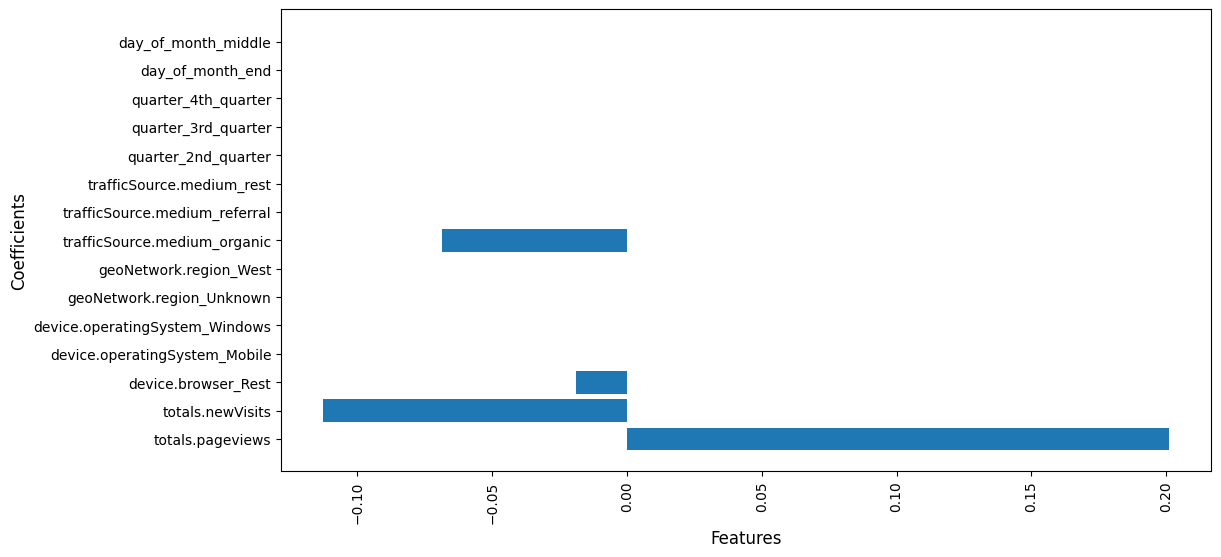

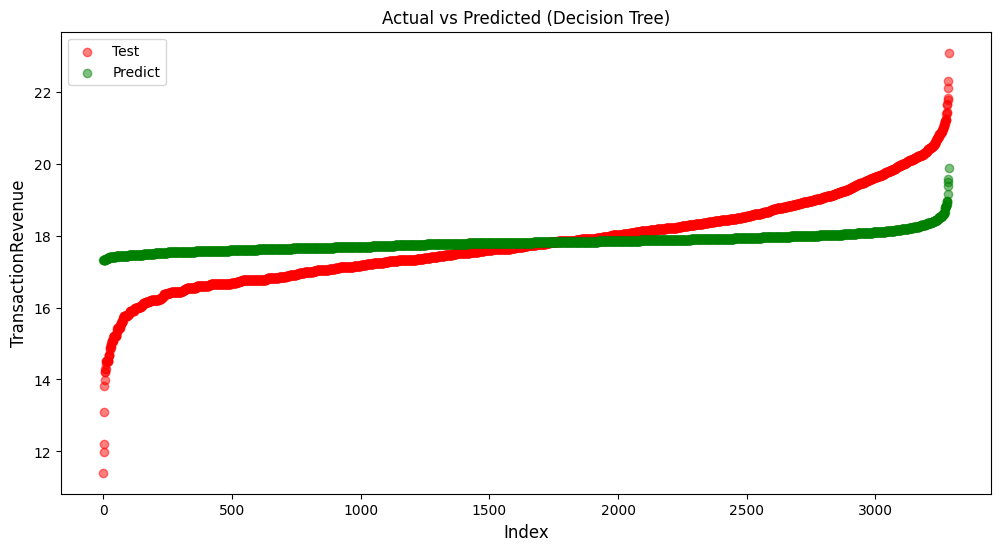

In [111]:
# lasso regression and ridge regression
from sklearn.linear_model import Lasso, Ridge

# Initialize the model
model = Lasso(alpha=0.1)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
dae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error lasso:", mse)
print("Mean Absolute Error lasso:", mae)
print("Median Absolute Error lasso:", dae)

# Perform 5-fold cross validation
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Print the cross-validated scores
print('Cross-validated scores lasso :', -scores)

# Print the average score
print('Average score lasso:', -scores.mean())

#plot the coefficients
plt.figure(figsize=(12,6))
plt.barh(X.columns, model.coef_)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Coefficients', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Deviation Plot between Predict and Test in different colors
plt.figure(figsize=(12,6))
plt.scatter(range(len(y_test)), np.sort(y_test), color='r', label='Test', alpha=0.5)
plt.scatter(range(len(y_pred)), np.sort(y_pred), color='g', label='Predict', alpha=0.5)
 
plt.xlabel('Index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.title('Actual vs Predicted (Decision Tree)')
plt.legend()
plt.show()



# Ridge Regression

Mean Squared Error ridge: 1.2553018409052679
Mean Absolute Error ridge: 0.8631836865844579
Median Absolute Error ridge: 0.6871210618560948
Cross-validated scores ridge : [0.85841856 0.81551492 0.85595857 0.8723664  0.8558236 ]
Average score ridge: 0.8516164129760136


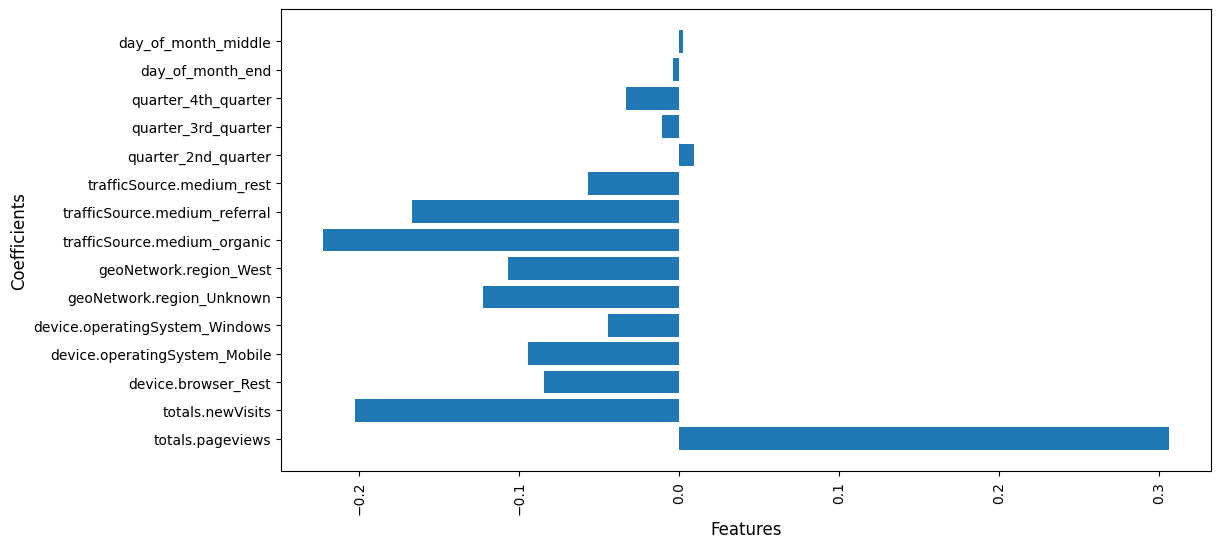

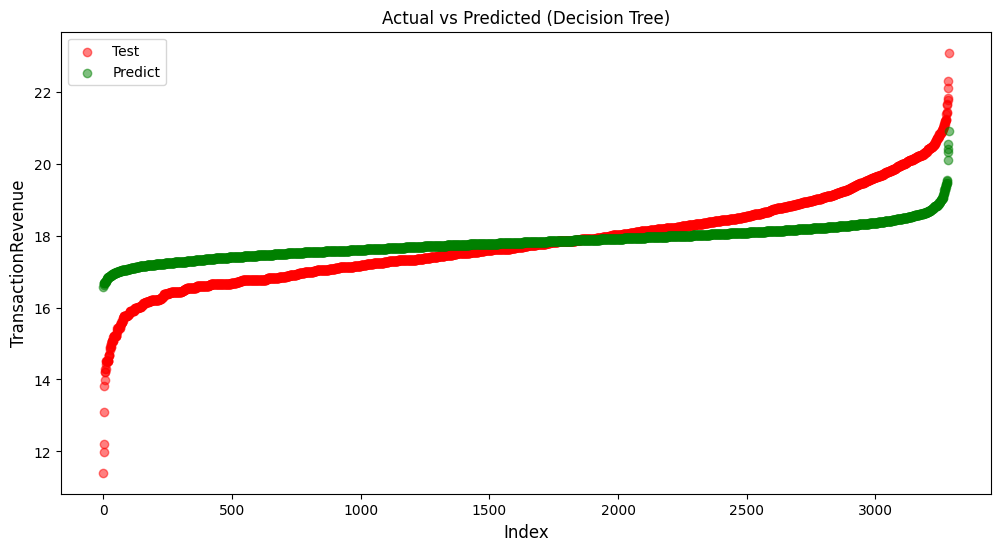

In [113]:
# Initialize the model
model = Ridge(alpha=0.1)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
dae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error ridge:", mse)
print("Mean Absolute Error ridge:", mae)
print("Median Absolute Error ridge:", dae)

# Perform 5-fold cross validation
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Print the cross-validated scores
print('Cross-validated scores ridge :', -scores)

# Print the average score
print('Average score ridge:', -scores.mean())

#plot the coefficients
plt.figure(figsize=(12,6))
plt.barh(X.columns, model.coef_)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Coefficients', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Deviation Plot between Predict and Test in different colors
plt.figure(figsize=(12,6))
plt.scatter(range(len(y_test)), np.sort(y_test), color='r', label='Test', alpha=0.5)
plt.scatter(range(len(y_pred)), np.sort(y_pred), color='g', label='Predict', alpha=0.5)
 
plt.xlabel('Index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.title('Actual vs Predicted (Decision Tree)')
plt.legend()
plt.show()


# Random Forest Regressor

Mean Squared Error rfr: 1.4767865786291972
Mean Absolute Error rfr: 0.9416846212787142
Median Absolute Error rfr: 0.7785681531636808
Cross-validated scores: [0.92595225 0.90835246 0.93342571 0.94780889 0.94403123]
Average score: 0.9319141078620603


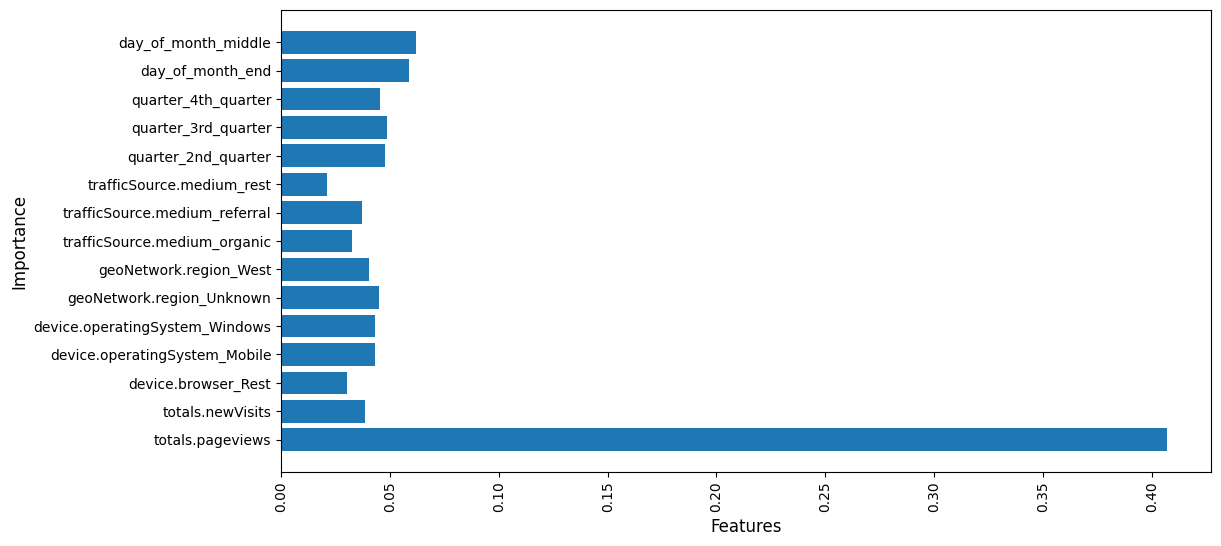

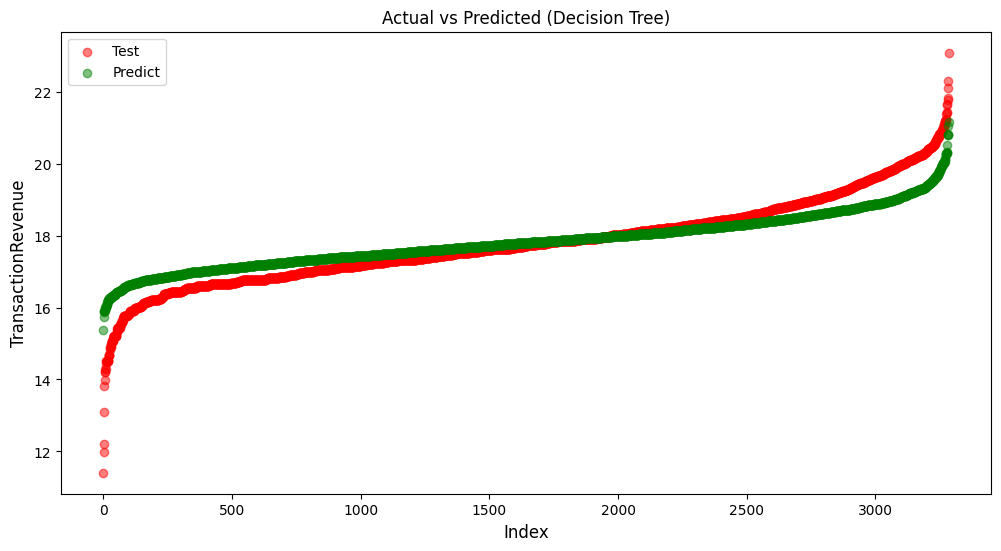

In [109]:
# other regression model
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
dae_rfr = median_absolute_error(y_test, y_pred)
mse_rfr = mean_squared_error(y_test, y_pred)
mae_rfr = mean_absolute_error(y_test, y_pred)




print("Mean Squared Error rfr:",mse_rfr)
print("Mean Absolute Error rfr:", mae_rfr)
print("Median Absolute Error rfr:", dae_rfr)


# Perform 5-fold cross validation
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Print the cross-validated scores
print('Cross-validated scores:', -scores)

# Print the average score
print('Average score:', -scores.mean())


#plot the feature importance
plt.figure(figsize=(12,6))
plt.barh(X.columns, model.feature_importances_)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Deviation Plot between Predict and Test in different colors
plt.figure(figsize=(12,6))
plt.scatter(range(len(y_test)), np.sort(y_test), color='r', label='Test', alpha=0.5)
plt.scatter(range(len(y_pred)), np.sort(y_pred), color='g', label='Predict', alpha=0.5)
 
plt.xlabel('Index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.title('Actual vs Predicted (Decision Tree)')
plt.legend()
plt.show()


# XGBRegressor

Mean Squared Error xgb: 1.359722321269476
Mean Absolute Error xgb: 0.901661119257582
Median Absolute Error xgb: 0.7384854120054509


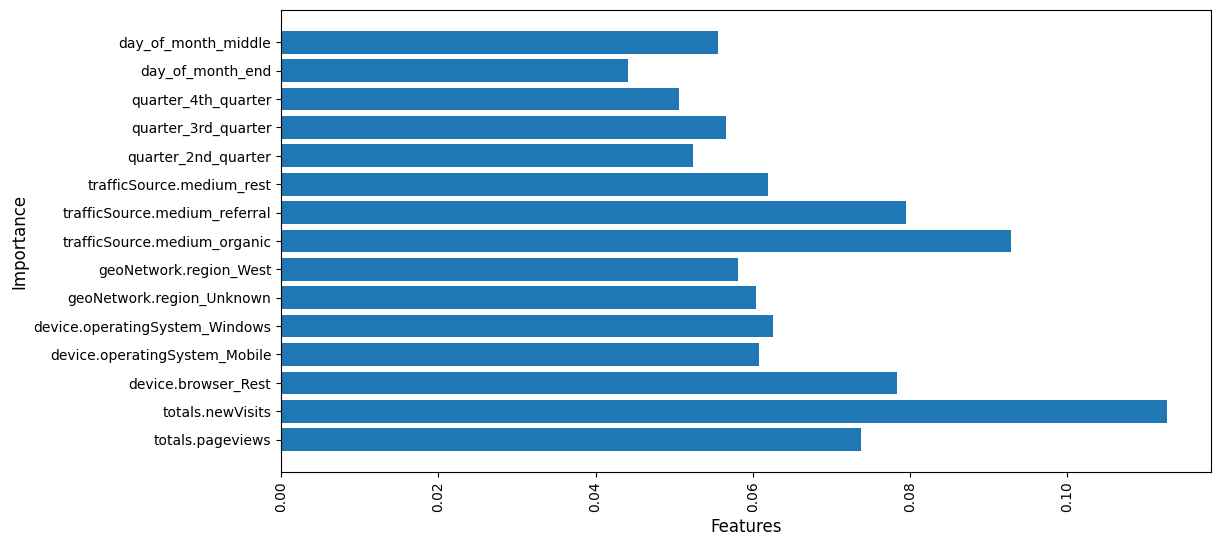

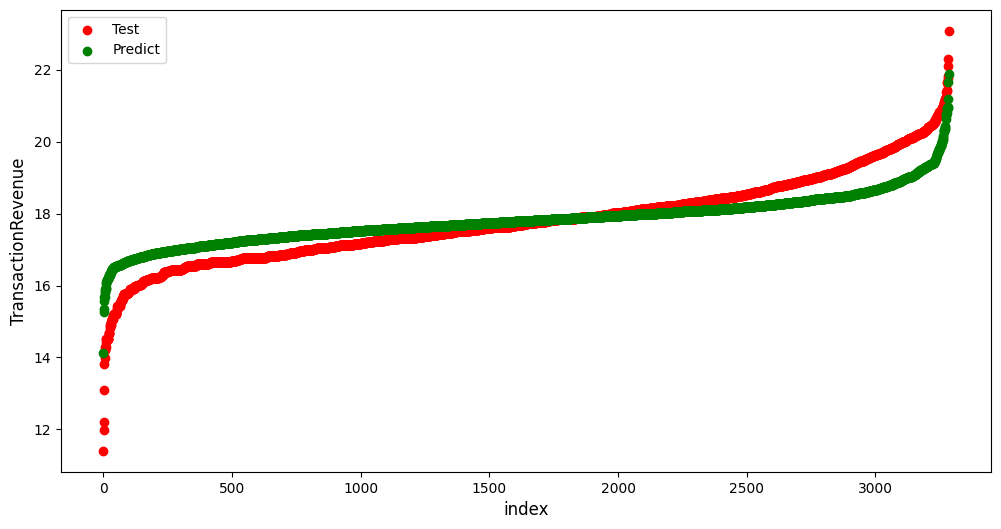

In [115]:
#xgb regression
# !pip install xgboost
import xgboost as xgb

# Initialize the model
model = xgb.XGBRegressor()

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
dae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error xgb:", mse)
print("Mean Absolute Error xgb:", mae)
print("Median Absolute Error xgb:", dae)

#plot the feature importance
plt.figure(figsize=(12,6))
plt.barh(X.columns, model.feature_importances_)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.xticks(rotation=90)
plt.show()
 
# Deviation Plot between Predict and Test in different colors
 
plt.figure(figsize=(12,6))
plt.scatter(range(y_test.shape[0]), np.sort(y_test), color='r', label='Test')
plt.scatter(range(y_pred.shape[0]), np.sort(y_pred), color='g', label='Predict')
 
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.legend()
plt.show()


# Gradient Boosting Regressor

Mean Squared Error gbr: 1.2198357316613986
Mean Absolute Error gbr: 0.8521492192858857
Median Absolute Error gbr: 0.6811395760995076
Cross-validated scores gbr : [0.84051362 0.80441982 0.84479044 0.86525018 0.84382516]
Average score gbr: 0.8397598450399484


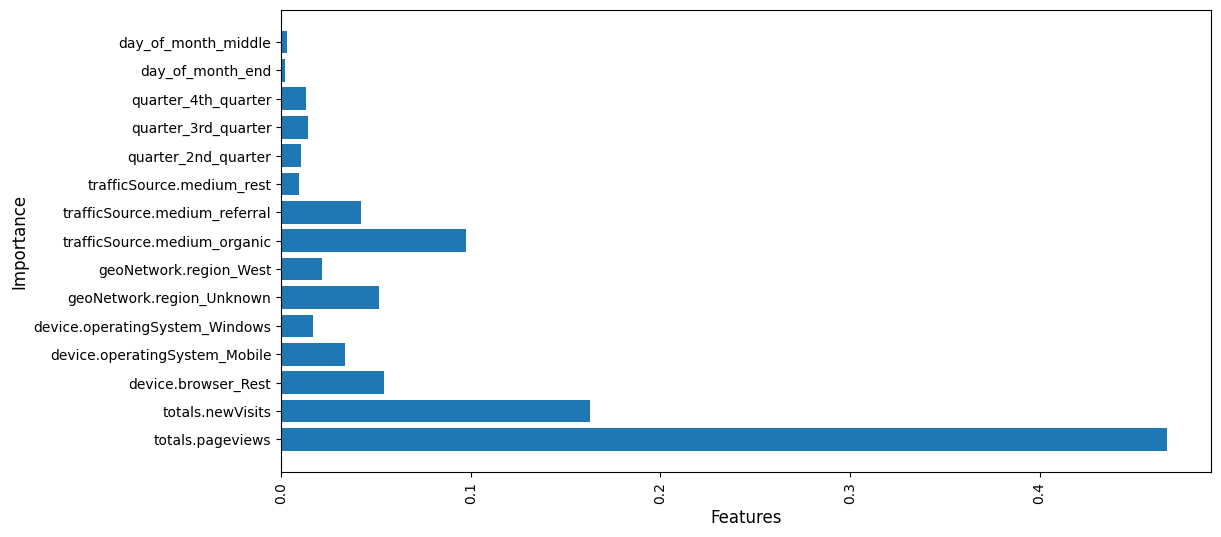

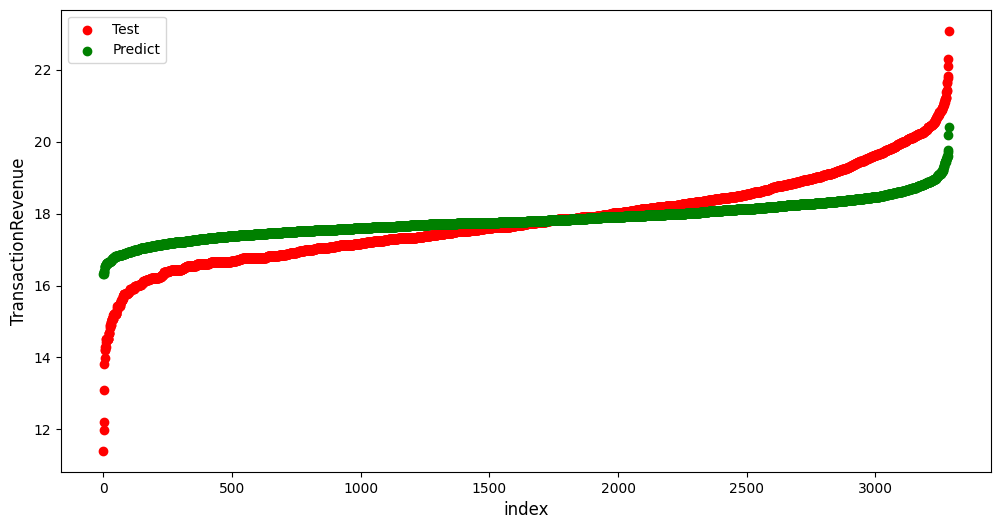

In [117]:
# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
 
# Initialize the model
model = GradientBoostingRegressor()
 
# Fit the model
model.fit(X_train, y_train)
 
# Make predictions
y_pred = model.predict(X_test)
 
# Evaluate the model
dae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
 
print("Mean Squared Error gbr:", mse)
print("Mean Absolute Error gbr:", mae)
print("Median Absolute Error gbr:", dae)
 
# Perform 5-fold cross validation
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
 
# Print the cross-validated scores
print('Cross-validated scores gbr :', -scores)
 
# Print the average score
print('Average score gbr:', -scores.mean())
 
#plot the feature importance
plt.figure(figsize=(12,6))
plt.barh(X.columns, model.feature_importances_)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.xticks(rotation=90)
plt.show()
 
# Deviation Plot between Predict and Test in different colors
 
plt.figure(figsize=(12,6))
plt.scatter(range(y_test.shape[0]), np.sort(y_test), color='r', label='Test')
plt.scatter(range(y_pred.shape[0]), np.sort(y_pred), color='g', label='Predict')
 
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.legend()
plt.show()

# Adaboost Regressor

Mean Squared Error adb: 1.3586355829176433
Mean Absolute Error adb: 0.9119676399170286
Median Absolute Error adb: 0.7734136030930969
Cross-validated scores adb: [0.88826738 0.83458079 0.89281908 0.90706688 0.89159633]
Average score adb: 0.8828660917444784


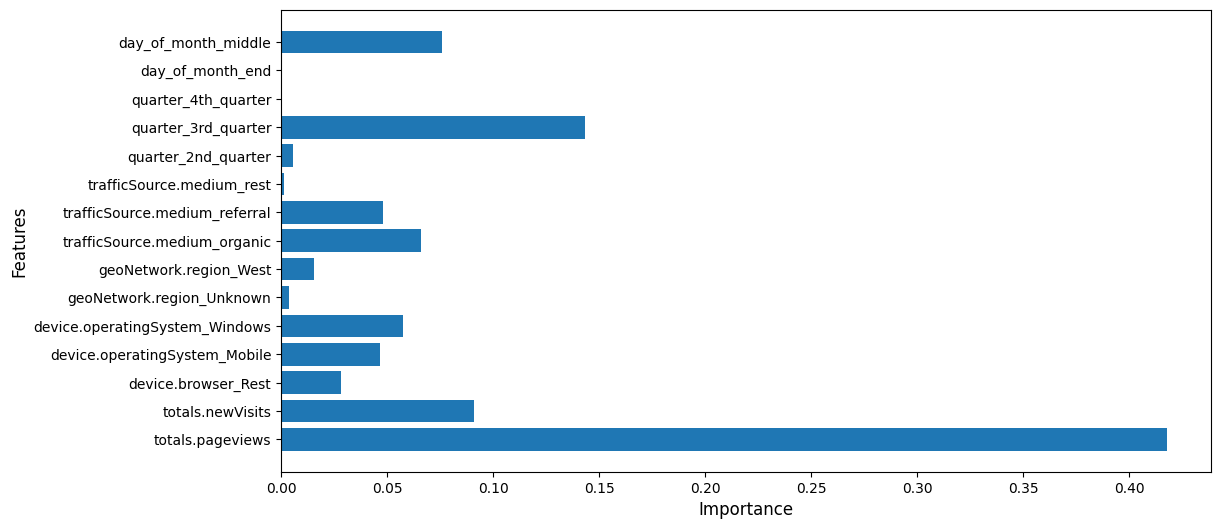

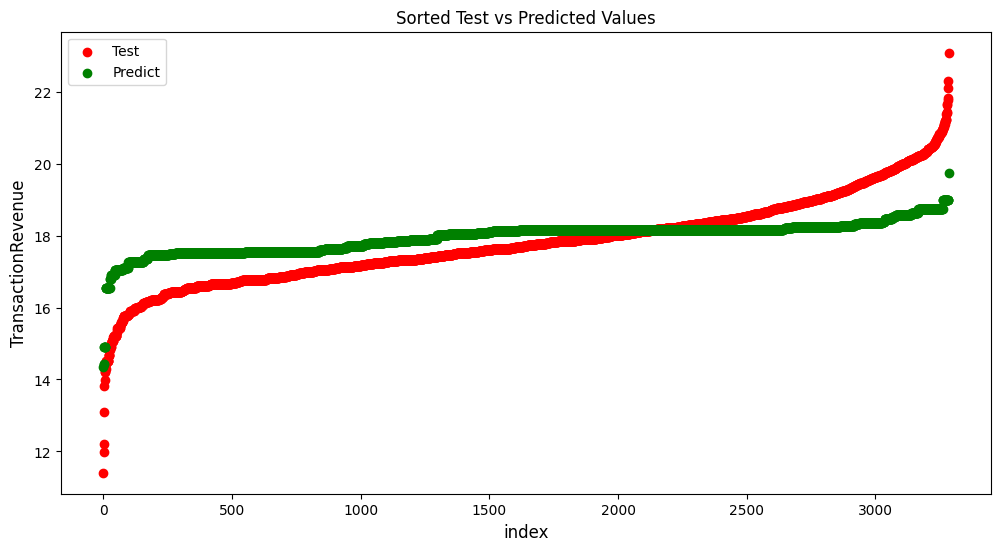

In [119]:
from sklearn.ensemble import AdaBoostRegressor
 
# Initialize the model
model = AdaBoostRegressor()
 
# Fit the model on the training data
model.fit(X_train, y_train)
 
# Make predictions on the test data
y_pred = model.predict(X_test)
 
# Evaluate the model
dae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
 
print("Mean Squared Error adb:", mse)
print("Mean Absolute Error adb:", mae)
print("Median Absolute Error adb:", dae)
 
# Perform 5-fold cross validation
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
 
# Print the cross-validated scores (negated to get positive values)
print('Cross-validated scores adb:', -scores)
 
# Print the average score
print('Average score adb:', -scores.mean())
 
# Plot the feature importance
plt.figure(figsize=(12,6))
# If your AdaBoostRegressor uses DecisionTreeRegressor as the base estimator (which is default),
# you can access feature importances. Otherwise, this might not be available.
if hasattr(model, 'feature_importances_'):
    plt.barh(X.columns, model.feature_importances_)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.show()
else:
    print('Feature importances are not available for the base estimator.')
 
# Deviation Plot between Predict and Test in different colors
plt.figure(figsize=(12,6))
plt.scatter(range(len(y_test)), np.sort(y_test), color='r', label='Test')
plt.scatter(range(len(y_pred)), np.sort(y_pred), color='g', label='Predict')
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.title('Sorted Test vs Predicted Values')
plt.legend()
plt.show()

# Decision Tree Regressor

Mean Squared Error (Decision Tree): 2.3221567527786764
Mean Absolute Error (Decision Tree): 1.1762292124994762
Median Absolute Error (Decision Tree): 0.9427609364398819
Cross-validated scores (Decision Tree): [1.16477989 1.15330121 1.17511061 1.18460591 1.19367968]
Average score (Decision Tree): 1.1742954597209285


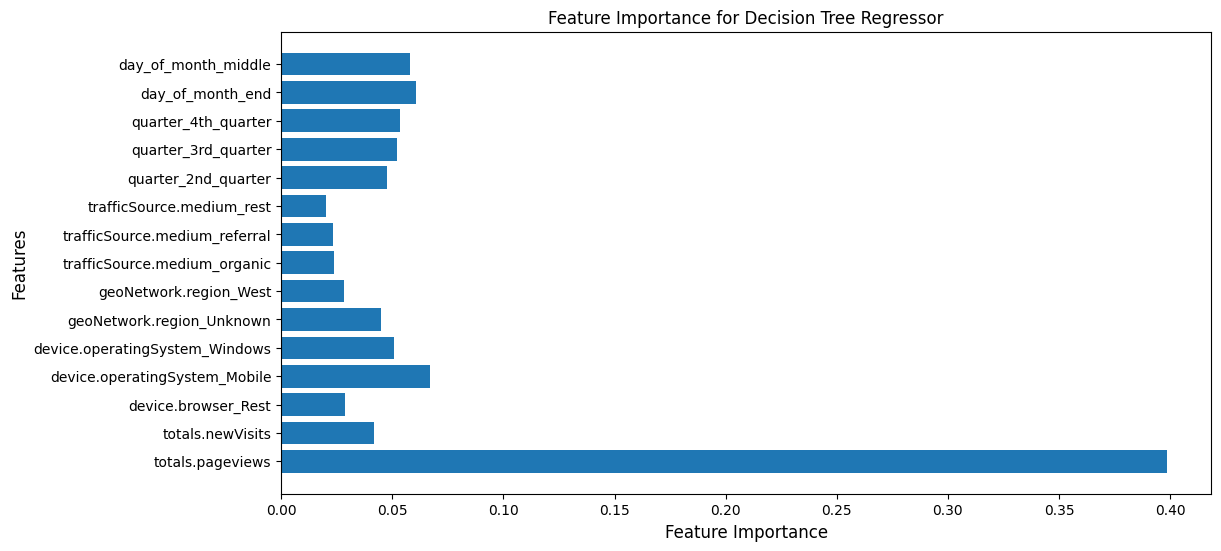

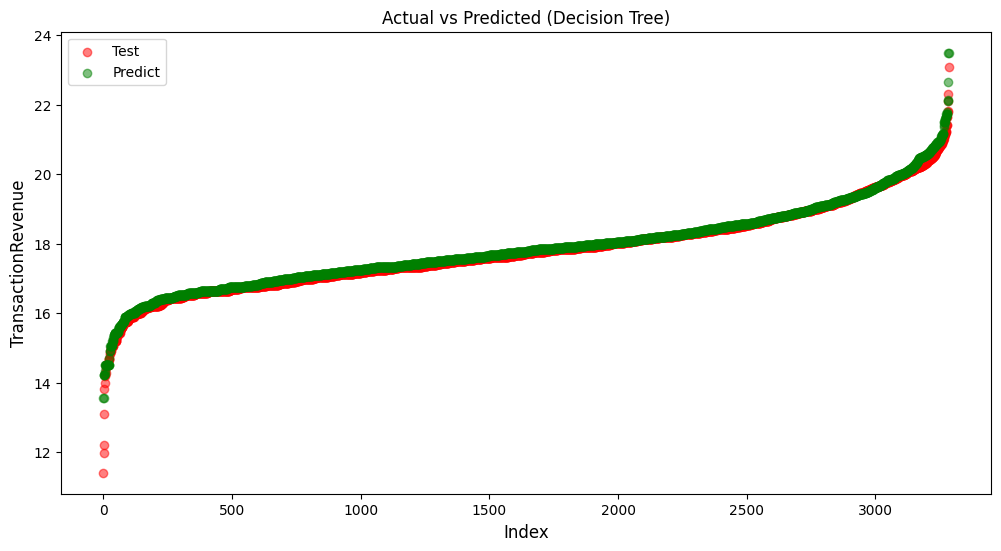

In [121]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
 
# Initialize the model
dt_model = DecisionTreeRegressor()
 
# Fit the model
dt_model.fit(X_train, y_train)
 
# Make predictions
y_pred_dt = dt_model.predict(X_test)
 
# Evaluate the model
mse_dt = mean_squared_error(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
dae_dt = median_absolute_error(y_test, y_pred_dt)
 
print("Mean Squared Error (Decision Tree):", mse_dt)
print("Mean Absolute Error (Decision Tree):", mae_dt)
print("Median Absolute Error (Decision Tree):", dae_dt)
 
# Perform 5-fold cross validation
scores_dt = cross_val_score(dt_model, X, y, cv=5, scoring='neg_mean_absolute_error')
 
# Print the cross-validated scores (as positive values)
print('Cross-validated scores (Decision Tree):', -scores_dt)
 
# Print the average score
print('Average score (Decision Tree):', -scores_dt.mean())
 
# Plot the feature importance
plt.figure(figsize=(12,6))
plt.barh(X.columns, dt_model.feature_importances_)
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance for Decision Tree Regressor')
plt.show()
 
# Deviation Plot between Predict and Test in different colors
plt.figure(figsize=(12,6))
plt.scatter(range(len(y_test)), np.sort(y_test), color='r', label='Test', alpha=0.5)
plt.scatter(range(len(y_pred_dt)), np.sort(y_pred_dt), color='g', label='Predict', alpha=0.5)
 
plt.xlabel('Index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.title('Actual vs Predicted (Decision Tree)')
plt.legend()
plt.show()
 

# Support Vector Regressor (SVR)

Mean Squared Error svr: 1.263903967205267
Mean Absolute Error svr: 0.8559893943765244
Median Absolute Error svr: 0.6714292679810061
Cross-validated scores svr : [0.84857646 0.80814385 0.84928007 0.8733592  0.85135905]
Average score svr: 0.8461437269566936


E:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but SVR was fitted without feature names

E:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but SVR was fitted without feature names

E:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but SVR was fitted without feature names

E:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but SVR was fitted without feature names

E:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but SVR was fitted without feature names

E:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but SVR was fitted without feature names

E:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but SVR was fitted without feature names

E:\ProgramDat

Feature: totals.pageviews, Score: 0.00049
Feature: totals.newVisits, Score: 0.00010
Feature: device.browser_Rest, Score: -0.00000
Feature: device.operatingSystem_Mobile, Score: 0.00002
Feature: device.operatingSystem_Windows, Score: -0.00002
Feature: geoNetwork.region_Unknown, Score: -0.00005
Feature: geoNetwork.region_West, Score: 0.00004
Feature: trafficSource.medium_organic, Score: 0.00004
Feature: trafficSource.medium_referral, Score: 0.00002
Feature: trafficSource.medium_rest, Score: -0.00001
Feature: quarter_2nd_quarter, Score: 0.00000
Feature: quarter_3rd_quarter, Score: -0.00000
Feature: quarter_4th_quarter, Score: -0.00000
Feature: day_of_month_end, Score: -0.00000
Feature: day_of_month_middle, Score: 0.00000


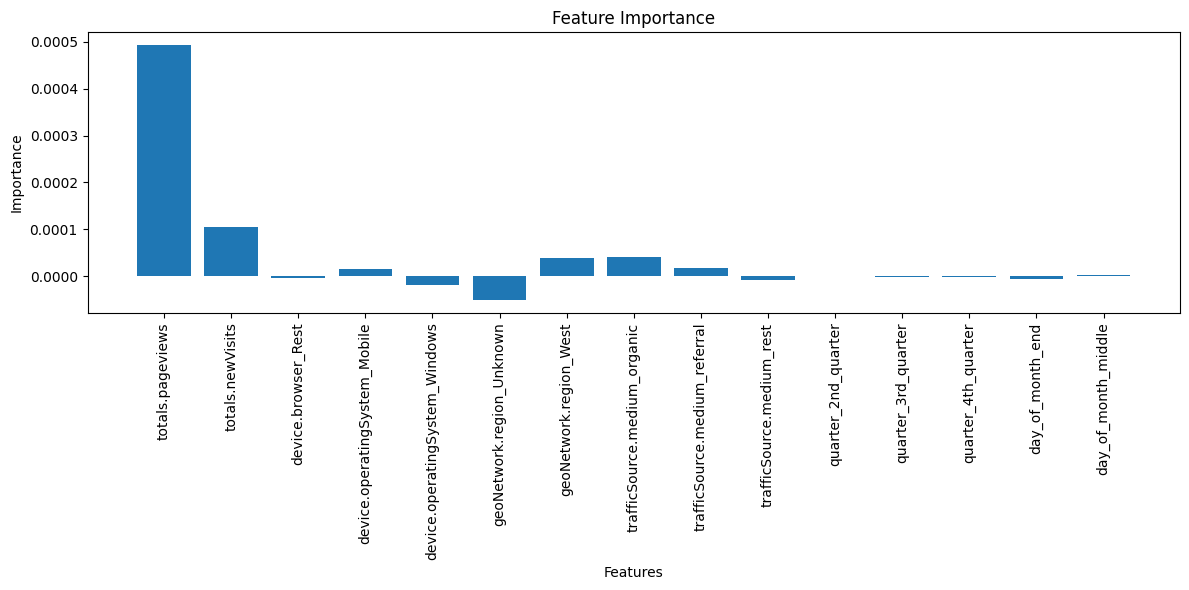

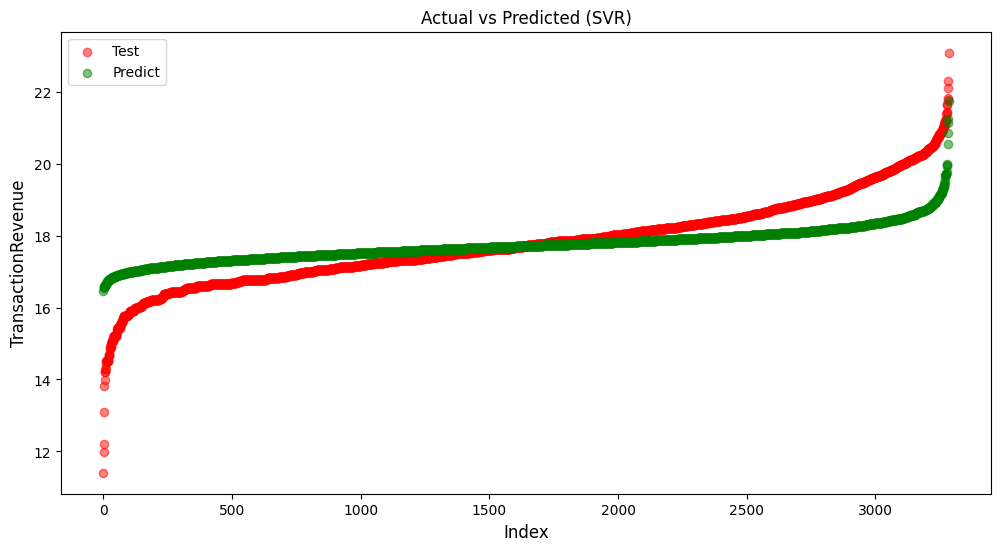

In [139]:
# SVR
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance

# Initialize the model
model = SVR(kernel='linear')
 
# Fit the model
model.fit(X_train, y_train)
 
# Make predictions
y_pred = model.predict(X_test)
 
# Evaluate the model
dae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
 
print("Mean Squared Error svr:", mse)
print("Mean Absolute Error svr:", mae)
print("Median Absolute Error svr:", dae)
 
# Perform 5-fold cross validation
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
 
# Print the cross-validated scores
print('Cross-validated scores svr :', -scores)
 
# Print the average score
print('Average score svr:', -scores.mean())
 
# Perform permutation importance
results = permutation_importance(model, X, y, scoring='neg_mean_absolute_error')
importance = results.importances_mean

# Summarize feature importance with feature names
feature_names = X.columns
for i, v in enumerate(importance):
    print(f"Feature: {feature_names[i]}, Score: {v:.5f}")

# Create a bar chart with feature names
plt.figure(figsize=(12, 6))
plt.bar(range(len(importance)), importance, tick_label=feature_names)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.xticks(rotation='vertical')  # Rotate feature names for better readability
plt.ylabel('Importance')
plt.tight_layout()

# Display the plot
plt.show()

# Deviation Plot between Predict and Test in different colors
plt.figure(figsize=(12,6))
plt.scatter(range(len(y_test)), np.sort(y_test), color='r', label='Test', alpha=0.5)
plt.scatter(range(len(y_pred)), np.sort(y_pred), color='g', label='Predict', alpha=0.5)
 
plt.xlabel('Index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.title('Actual vs Predicted (SVR)')
plt.legend()
plt.show()


# Hyperparameter Tuning

# Ridge Regression

In [124]:
#Tuning on Ridge Regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Initialize the model
model = Ridge()

# Define the hyperparameters
hyperparameters = {'alpha': [0.1, 0.01, 0.001, 0.0001, 0.00001]}

# Initialize the grid search
grid_search = GridSearchCV(model, hyperparameters, cv=5, scoring='neg_mean_absolute_error')

# Fit the data to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters
print('Best parameters: ', grid_search.best_params_)

# Print the best score
print("Mean Absolute Error using Ridge: ",-1*grid_search.best_score_)

Best parameters:  {'alpha': 1e-05}
Mean Absolute Error using Ridge:  0.8482603121068019


# Lasso Regression

In [125]:
#Tuning on Lasso Regression

# Initialize the model
model = Lasso()

# Define the hyperparameters
hyperparameters = {'alpha': [0.1, 0.01, 0.001, 0.0001, 0.00001]}

# Initialize the grid search
grid_search = GridSearchCV(model, hyperparameters, cv=5, scoring='neg_mean_absolute_error')

# Fit the data to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters
print('Best parameters: ', grid_search.best_params_)

# Print the best score
print("Mean Absolute Error using Lasso: ",-1*grid_search.best_score_)

Best parameters:  {'alpha': 0.001}
Mean Absolute Error using Lasso:  0.8481835895444814


# Random Forest Regression

In [126]:
#Tuning on Random Forest Regression

# Initialize the model
model = RandomForestRegressor()

# Define the hyperparameters
hyperparameters = {'n_estimators': [100, 200, 300, 400],
                   'max_depth': [2,4,6],
                   'min_samples_leaf': [1,2,3],
                   'min_samples_split': [2,5,10]}

# Initialize the grid search
grid_search = GridSearchCV(model, hyperparameters, cv=5, scoring='neg_mean_absolute_error')

# Fit the data to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters
print('Best parameters: ', grid_search.best_params_)

# Print the best score
print("Mean Absolute Error using Random Forest: ",-1*grid_search.best_score_)

Best parameters:  {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 400}
Mean Absolute Error using Random Forest:  0.8378606591354518


# XGB Regressor

In [127]:
#Tuning on XGBoost Regressor

# Initialize the model
model = xgb.XGBRegressor(objective ='reg:squarederror')

# Define the hyperparameters
hyperparameters = {'n_estimators': [100, 200, 300, 400],
                   'max_depth': [2,4,6],
                   'learning_rate': [0.1, 0.01, 0.001]}

# Initialize the grid search
grid_search = GridSearchCV(model, hyperparameters, cv=5, scoring='neg_mean_absolute_error')

# Fit the data to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters
print('Best parameters: ', grid_search.best_params_)

# Print the best score
print("Mean Absolute Error using XGBRegressor: ",-1*grid_search.best_score_)

Best parameters:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 400}
Mean Absolute Error using XGBRegressor:  0.8347359576414437


# Gradient Boosting Regressor

In [128]:
#Tuning on Gradient Boosting Regression

# Initialize the model
model = GradientBoostingRegressor()

# Define the hyperparameters
hyperparameters = {'n_estimators': [100, 200, 300],
                   'max_depth': [2,4,6],
                   'min_samples_leaf': [1,2,3],
                   'min_samples_split': [2,5,10]}

# Initialize the grid search
grid_search = GridSearchCV(model, hyperparameters, cv=5, scoring='neg_mean_absolute_error')

# Fit the data to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters
print('Best parameters: ', grid_search.best_params_)

# Print the best score
print("Mean Absolute Error using Gradient Boosting Regressor: ",-1*grid_search.best_score_)

Best parameters:  {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Mean Absolute Error using Gradient Boosting Regressor:  0.8346977759722577


# AdaBoost Regressor

In [129]:
#Tuning on AdaBoost Regression Model

# Initialize the model
model = AdaBoostRegressor()

# Define the hyperparameters
hyperparameters = {'n_estimators': [100, 200, 300, 400],
                   'learning_rate': [0.1, 0.01, 0.001]}

# Initialize the grid search
grid_search = GridSearchCV(model, hyperparameters, cv=5, scoring='neg_mean_absolute_error')

# Fit the data to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters
print('Best parameters: ', grid_search.best_params_)

# Print the best score
print("Mean Absolute Error using AdaBoost Regressor: ",-1*grid_search.best_score_)

Best parameters:  {'learning_rate': 0.01, 'n_estimators': 200}
Mean Absolute Error using AdaBoost Regressor:  0.8568426502210416


# Decision Tree Regressor

In [130]:
#Tuning on Decision Tree Regression Model

# Initialize the model
model = DecisionTreeRegressor()

# Define the hyperparameters
hyperparameters = {'max_depth': [2,4,6],
                   'min_samples_leaf': [1,2,3],
                   'min_samples_split': [2,5,10]}

# Initialize the grid search
grid_search = GridSearchCV(model, hyperparameters, cv=5, scoring='neg_mean_absolute_error')

# Fit the data to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters
print('Best parameters: ', grid_search.best_params_)

# Print the best score
print("Mean Absolute Error using Decision Tree Regressor: ",-1*grid_search.best_score_)

Best parameters:  {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 10}
Mean Absolute Error using Decision Tree Regressor:  0.8538511314431071


# Support Vector Regressor

In [131]:
#Tuning on Support Vector Regression Model

# Initialize the model
model = SVR()

# Define the hyperparameters
hyperparameters = {'C': [0.1, 1, 10, 100],
                   'gamma': [1, 0.1, 0.01, 0.001]}

# Initialize the grid search
grid_search = GridSearchCV(model, hyperparameters, cv=5, scoring='neg_mean_absolute_error')

# Fit the data to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters
print('Best parameters: ', grid_search.best_params_)

# Print the best score
print("Mean Absolute Error using SVR: ",-1*grid_search.best_score_)

Best parameters:  {'C': 1, 'gamma': 0.01}
Mean Absolute Error using SVR:  0.8318002798684683
